# Poisson regression (GAM) COVID-19 Prediction

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

plotly.offline.init_notebook_mode()
sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from pygam import PoissonGAM, s, l, f

# Other
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotting import plot_predictions
from stem_poisson_gam import preprocess_data, StemPoissonRegressor
from utils import get_covid_data, get_all_covid_data

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## About

The goal is to provide the most accurate forecasts for COVID-19 in Canada for new cases, deaths and recovered cases.  We'll be using an approach similar to that in the paper [Spatiotemporal Dynamics, Nowcasting and Forecasting of COVID-19 in the United States](https://arxiv.org/abs/2004.14103) which uses a generalized additive model with Poisson distribution using temporal variables (number of infected, susceptible cases at time $t-1$), spatial coordinates, time varying covariates (control measures), and constant covariates (demographic, economic, etc). For now we only use temporal variables $I_{it}$ and $Z_{it}$.

## Load data and EDA

**Given variables**
- $Y_{it}$: Current number of new case at time t for area i. Column "cases" in cases_timeseries_prov.csv
- $I_{it}$: Cumulative number of active infectious cases. Column "active_cases" in active_timeseries_prov.csv
- $C_{it}$: Cumulative confirmed cases up to time t. Column "cumulative_cases" in active_timeseries_prov.csv
- $R_{it}$: Cumulative number of infections. Column "cumulative_recovered" in active_timeseries_prov.csv

**Transformed variables**
- $N_{i}$: Population of region i. Column "population"
- $\Delta D_{it}$: New deaths/recovered cases at time t. Column "removed"
- $S_{it}$: Number of susceptible subjects at time t defined by $S_{it} = N_i - C_{it}$. Column "susceptible"
- $Z_{it}$: Log ratio of susceptible subjects $Z_{it} = log(S_{it} / N_i)$. Column "percent_susceptible" without log transform.

In [2]:
# # Read in data
# data_path = '../data/timeseries_prov'
# cases_provinces = pd.read_csv(data_path + '/cases_timeseries_prov.csv')
# active_cases_provinces = pd.read_csv(data_path +  '/active_timeseries_prov.csv')
# mortality_provinces = pd.read_csv(data_path + '/mortality_timeseries_prov.csv')
# recovered_provinces = pd.read_csv(data_path + '/recovered_timeseries_prov.csv')

# # Province population data
# prov_map = {
#     'British Columbia': 'BC',
#     'Newfoundland and Labrador': 'NL', 
#     'Northwest Territories': 'NWT',
#     'Prince Edward Island': 'PEI'
# }

# province_populations = (
#     pd.read_csv('../data/canada_prov_population.csv')
#     .rename(columns = {'GEO': 'province', 'VALUE': 'population'})
#     .replace({'province': prov_map})
#     .loc[:, ['province', 'population']]
# )


# # Preprocessing dataframes to be merged
# recovered_provinces = recovered_provinces.rename(columns = {'date_recovered': 'date'}).loc[:, ['province', 'date', 'recovered']]
# mortality_provinces = mortality_provinces.rename(columns = {'date_death_report': 'date'}).loc[:, ['province', 'date', 'deaths']]

# # Preprocessing
# format = "%d-%m-%Y"
# active_cases_provinces = (
#     active_cases_provinces
#     .rename(columns = {"date_active": "date"})
    
#     # Merge deaths and recovered data
#     .merge(mortality_provinces, how='left', on=['province', 'date'])
#     .merge(recovered_provinces, how='left', on=['province', 'date'])
#     .fillna(0)
    
#     # Format date and add new cases data
#     .assign(date = lambda x: pd.to_datetime(x["date"], format=format).dt.date,
#             cases = cases_provinces['cases'])
#     .query('province != "Repatriated"')
    
#     # Add population data per province
#     .merge(province_populations, how='left', on='province')
    
#     # Add transformed variables
#     .assign(removed = lambda x: x['recovered'] + x['deaths'],
#             susceptible = lambda x: x['population'] - x['cumulative_cases'],
#             percent_susceptible = lambda x: x['susceptible'] / x['population'])
# )

active_cases_provinces = get_all_covid_data(level='prov')

# Get first and last day of reports
start_date = active_cases_provinces["date"].min()
end_date = active_cases_provinces["date"].max()

# Get list of provinces
provinces = active_cases_provinces["province"].unique()
provinces = ['Ontario', 'Quebec', 'BC', 'Alberta']

# Show dataframe
active_cases_provinces.head(10)

province        date  cumulative_cases  cumulative_recovered  \
0  Alberta  2020-01-25                 0                     0   
1  Alberta  2020-01-26                 0                     0   
2  Alberta  2020-01-27                 0                     0   
3  Alberta  2020-01-28                 0                     0   
4  Alberta  2020-01-29                 0                     0   
5  Alberta  2020-01-30                 0                     0   
6  Alberta  2020-01-31                 0                     0   
7  Alberta  2020-02-01                 0                     0   
8  Alberta  2020-02-02                 0                     0   
9  Alberta  2020-02-03                 0                     0   

   cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
0                  0             0                    0       0          0   
1                  0             0                    0       0          0   
2                  0             0                    0       0          0   
3                  0             0                    0       0          0   
4                  0             0                    0       0          0   
5                  0             0                    0       0          0   
6                  0             0                    0       0          0   
7                  0             0                    0       0          0   
8                  0             0                    0       0          0   
9                  0             0                    0       0          0   

   cases  population  removed  susceptible  percent_susceptible  
0      0     4421876        0      4421876                  1.0  
1      0     4421876        0      4421876                  1.0  
2      0     4421876        0      4421876                  1.0  
3      0     4421876        0      4421876                  1.0  
4      0     4421876        0      4421876                  1.0  
5      0     4421876        0      4421876                  1.0  
6      0     4421876        0      4421876                  1.0  
7      0     4421876        0      4421876                  1.0  
8      0     4421876        0      4421876                  1.0  
9      0     4421876        0      4421876                  1.0

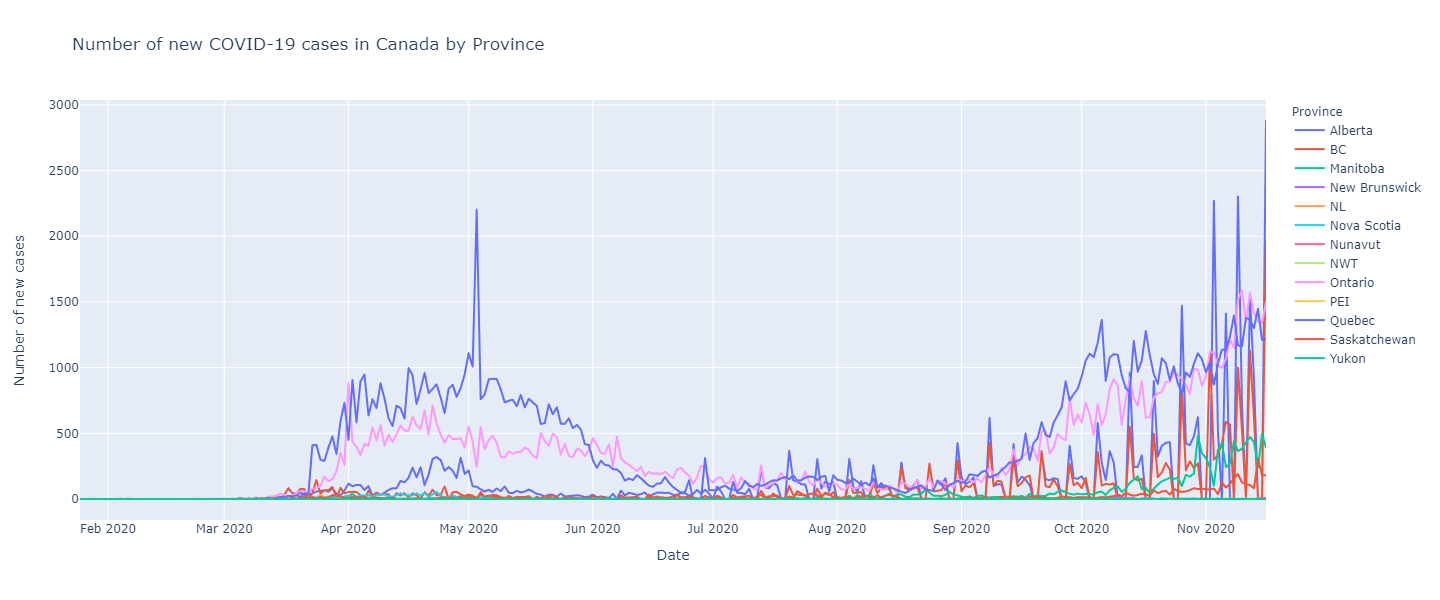

In [3]:
# Plot Y_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cases",
    color="province",
    title="Number of new COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cases="Number of new cases",
        province="Province",
    ),
    height=600,
)
fig.show()

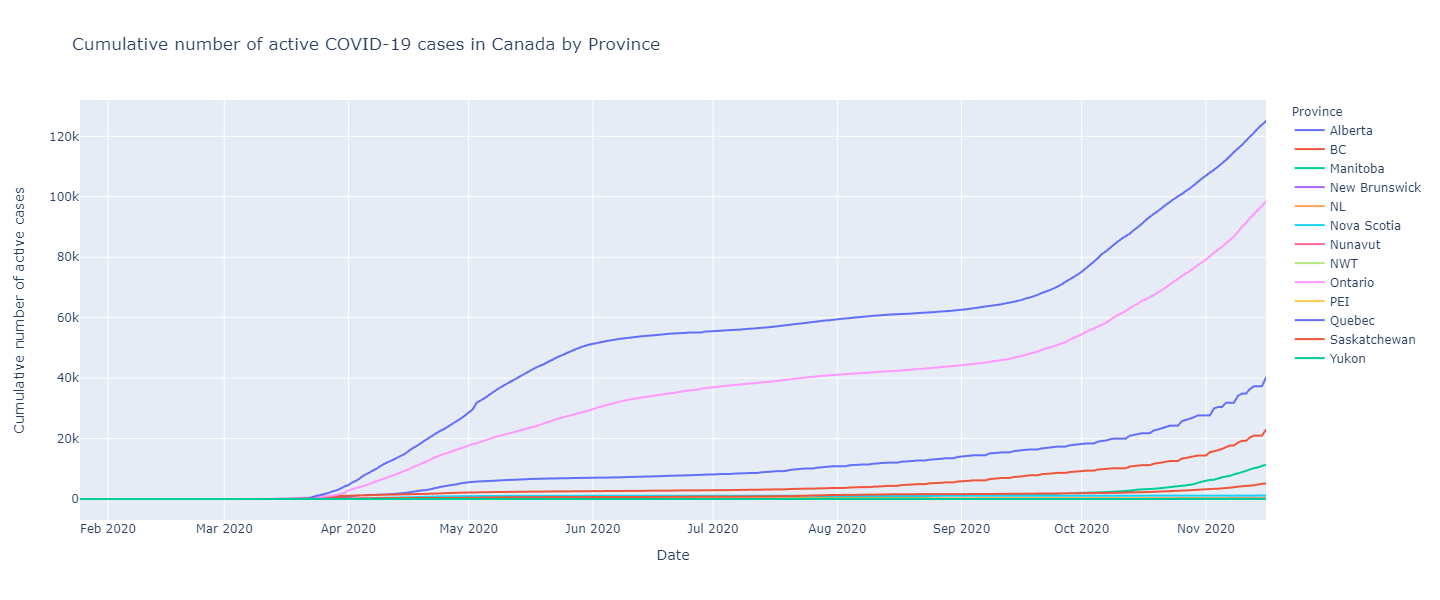

In [4]:
# Plot C_it cumulative active cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cumulative_cases",
    color="province",
    title="Cumulative number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cumulative_cases="Cumulative number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

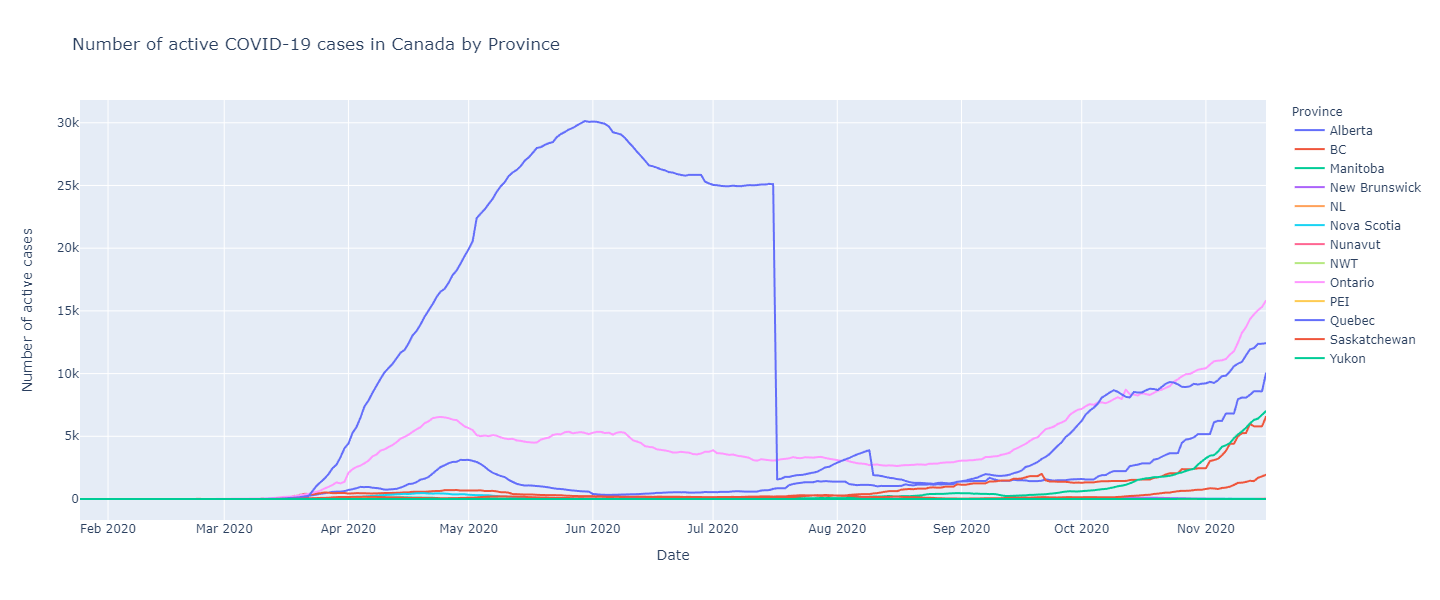

In [5]:
# Plot I_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="active_cases",
    color="province",
    title="Number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        active_cases="Number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

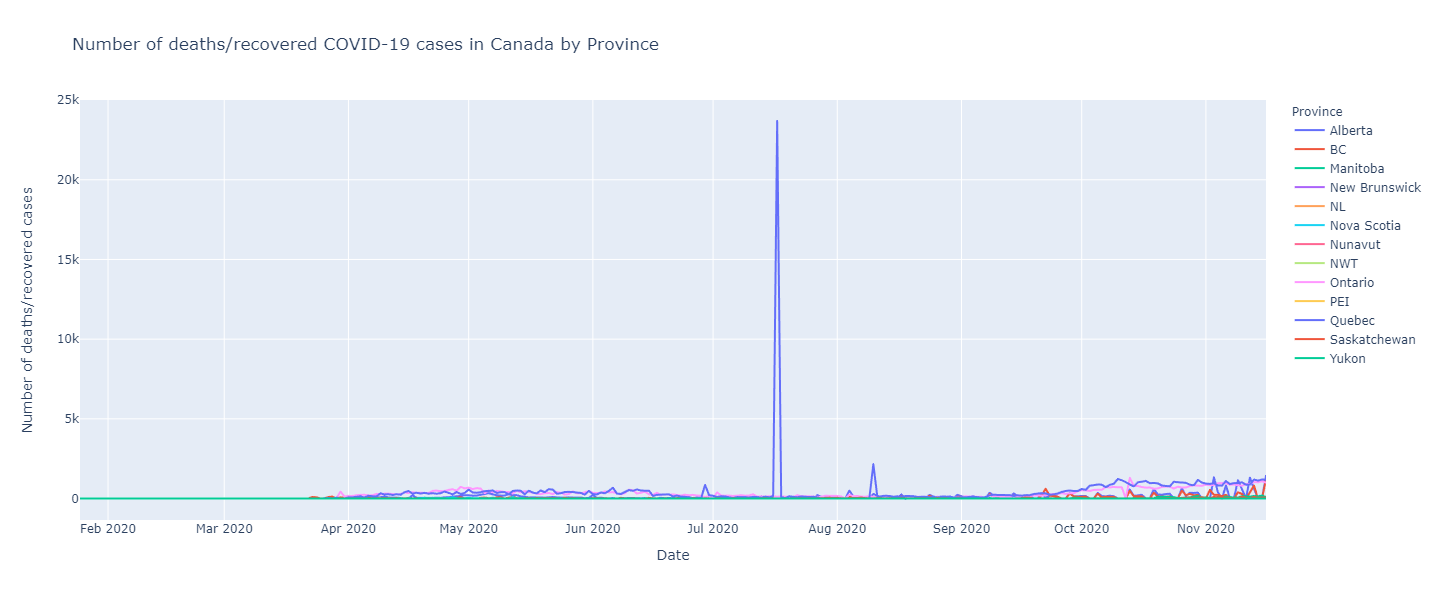

In [6]:
# Plot delta D_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="removed",
    color="province",
    title="Number of deaths/recovered COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        removed="Number of deaths/recovered cases",
        province="Province",
    ),
    height=600,
)
fig.show()

In [7]:
# Check latest date of data for each province
active_cases_provinces.sort_values('date').groupby('province').tail(1)

province        date  cumulative_cases  cumulative_recovered  \
2672        Ontario  2020-11-16             98509                 79295   
2375            NWT  2020-11-16                15                    10   
2969            PEI  2020-11-16                68                    64   
890        Manitoba  2020-11-16             11339                  4156   
593              BC  2020-11-16             22947                 16087   
3266         Quebec  2020-11-16            125072                105998   
2078        Nunavut  2020-11-16                26                     0   
1781    Nova Scotia  2020-11-16              1146                  1058   
3563   Saskatchewan  2020-11-16              5182                  3223   
296         Alberta  2020-11-16             40189                 29731   
1187  New Brunswick  2020-11-16               375                   341   
1484             NL  2020-11-16               303                   289   
3860          Yukon  2020-11-16                24                    22   

      cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
2672               3402         15812                  496      11        992   
2375                  0             5                    0       0          0   
2969                  0             4                    0       0          0   
890                 172          7011                  296      10         86   
593                 299          6561                  767       9       1186   
3266               6651         12423                   43      25       1150   
2078                  0            26                    8       0          0   
1781                 65            23                    2       0          0   
3563                 31          1928                  121       0         60   
296                 427         10031                 1447      20       1410   
1187                  6            28                    6       0          2   
1484                  4            10                    0       0          0   
3860                  1             1                    0       0          0   

      cases  population  removed  susceptible  percent_susceptible  
2672   1499    14734014     1003     14635505             0.993314  
2375      0       45161        0        45146             0.999668  
2969      0      159625        0       159557             0.999574  
890     392     1379263       96      1367924             0.991779  
593    1962     5147712     1195      5124765             0.995542  
3266   1218     8574571     1175      8449499             0.985414  
2078      8       39353        0        39327             0.999339  
1781      2      979351        0       978205             0.998830  
3563    181     1178681       60      1173499             0.995604  
296    2877     4421876     1430      4381687             0.990911  
1187      8      781476        2       781101             0.999520  
1484      0      522103        0       521800             0.999420  
3860      0       42052        0        42028             0.999429

In [8]:
# Remove data before March 8
remove_date = date(day=8, month=3, year=2020)
active_cases_provinces = active_cases_provinces.query("date >= @remove_date")

# Ignore provinces with very little cases
provinces_ignore = ['PEI', 'New Brunswick', 'NWT', 'NL', 'Nova Scotia', 'Nunavut', 'Yukon']
active_cases_provinces = active_cases_provinces.query("province not in @provinces_ignore").reset_index(drop=True)

### Comments

- Seems to be a seasonal component in the $Y_{it}$ plot of about 1 week appeearing roughly on Mondays and Tuesdays. This could be that the most testing happens over the weekends and thus the cases are displayed the start of the next week.
- Large dip in active cases in Quebec on July 17 - https://globalnews.ca/news/7190163/canada-coronavirus-cases-july-17/
- Spike in new cases in Quebec on May 3- https://www.cbc.ca/news/canada/montreal/covid-19-quebec-may-3-1.5553881
- Warning: Innacurate measurements of new and active cases, recovered, deaths, etc such as this could add too much noise and lead to poor model performance. Might be a good idea to ignore that portion of Quebec and use the latest data instead.
- Mortality data starts March 8, 2020 so we will just ignore all dates before March 1. 
- We will also be ignoring provinces with very few cases as they don't provide much information and predicting covid cases for those provinces is not as important as the major provinces

## Poisson regression

For a given province $i$ we have

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{t-1} + 1) + \alpha_tlog(S_{t-1}/N) 
$$

and

$$
\Delta D_t \sim Poisson({\mu_t}^D) \\
log({\mu_t}^D) = \beta_{1t}^D + \beta_{2t}^D log(I_{t-1} + 1)
$$

We will also be applying cross-validation on each fold to prevent overfitting.

In [9]:
# Preprocess data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

### Linear terms GAM

In [10]:
# Fit model
model = StemPoissonRegressor(lam_main=0.6, lam_other=100)
model.fit(X, Y)

In [11]:
# Get 3 week forecasts
forecasts = model.forecast(h=21)
forecasts = forecasts.merge(active_cases_provinces, how='left', on=['province', 'date'])

forecasts.tail(10)

province        date  active_cases_pred   cases_pred  removed_pred  \
1634      Manitoba  2020-12-06        7010.760538   537.254009    537.274327   
1635       Ontario  2020-12-06       15749.535636  1718.446363   1724.070563   
1636        Quebec  2020-12-06       12208.987172  1888.443922   1907.288780   
1637  Saskatchewan  2020-12-06        1928.306758   214.474782    214.446568   
1638       Alberta  2020-12-07       10031.710739  1068.261594   1068.219359   
1639            BC  2020-12-07        6564.279444   748.786116    748.503483   
1640      Manitoba  2020-12-07        7010.739324   537.460680    537.481893   
1641       Ontario  2020-12-07       15743.652536  1716.768425   1722.651525   
1642        Quebec  2020-12-07       12189.301934  1885.867460   1905.552698   
1643  Saskatchewan  2020-12-07        1928.336332   214.525189    214.495615   

     is_forecast  cumulative_cases  cumulative_recovered  cumulative_deaths  \
1634        True               NaN                   NaN                NaN   
1635        True               NaN                   NaN                NaN   
1636        True               NaN                   NaN                NaN   
1637        True               NaN                   NaN                NaN   
1638        True               NaN                   NaN                NaN   
1639        True               NaN                   NaN                NaN   
1640        True               NaN                   NaN                NaN   
1641        True               NaN                   NaN                NaN   
1642        True               NaN                   NaN                NaN   
1643        True               NaN                   NaN                NaN   

      active_cases  active_cases_change  deaths  recovered  cases  population  \
1634           NaN                  NaN     NaN        NaN    NaN         NaN   
1635           NaN                  NaN     NaN        NaN    NaN         NaN   
1636           NaN                  NaN     NaN        NaN    NaN         NaN   
1637           NaN                  NaN     NaN        NaN    NaN         NaN   
1638           NaN                  NaN     NaN        NaN    NaN         NaN   
1639           NaN                  NaN     NaN        NaN    NaN         NaN   
1640           NaN                  NaN     NaN        NaN    NaN         NaN   
1641           NaN                  NaN     NaN        NaN    NaN         NaN   
1642           NaN                  NaN     NaN        NaN    NaN         NaN   
1643           NaN                  NaN     NaN        NaN    NaN         NaN   

      removed  susceptible  percent_susceptible  
1634      NaN          NaN                  NaN  
1635      NaN          NaN                  NaN  
1636      NaN          NaN                  NaN  
1637      NaN          NaN                  NaN  
1638      NaN          NaN                  NaN  
1639      NaN          NaN                  NaN  
1640      NaN          NaN                  NaN  
1641      NaN          NaN                  NaN  
1642      NaN          NaN                  NaN  
1643      NaN          NaN                  NaN

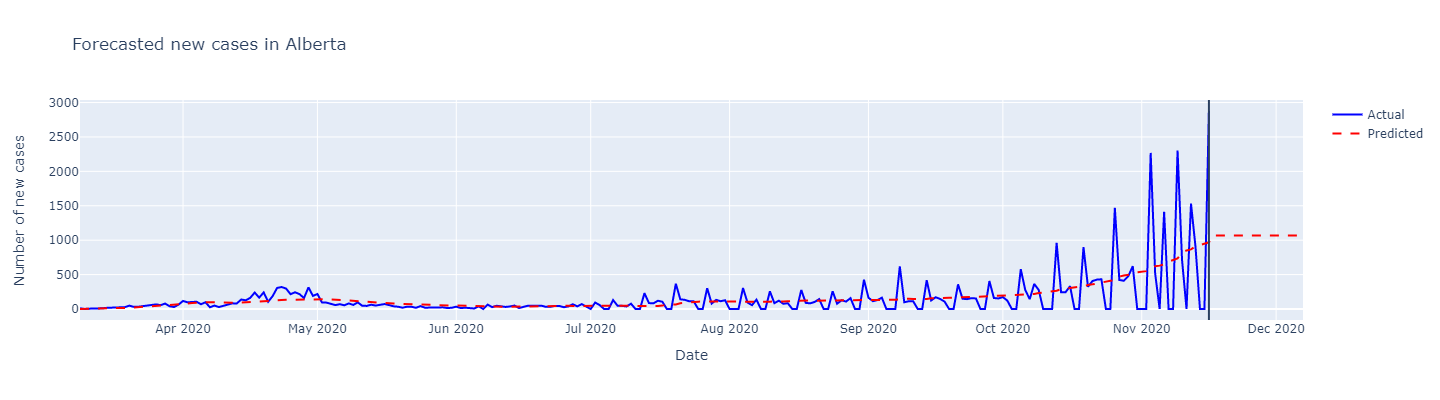

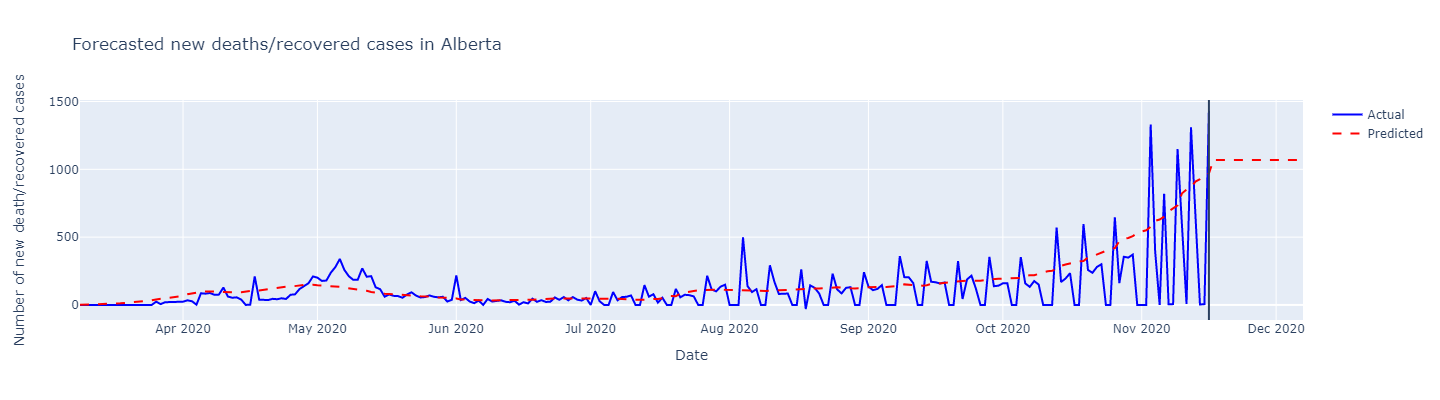

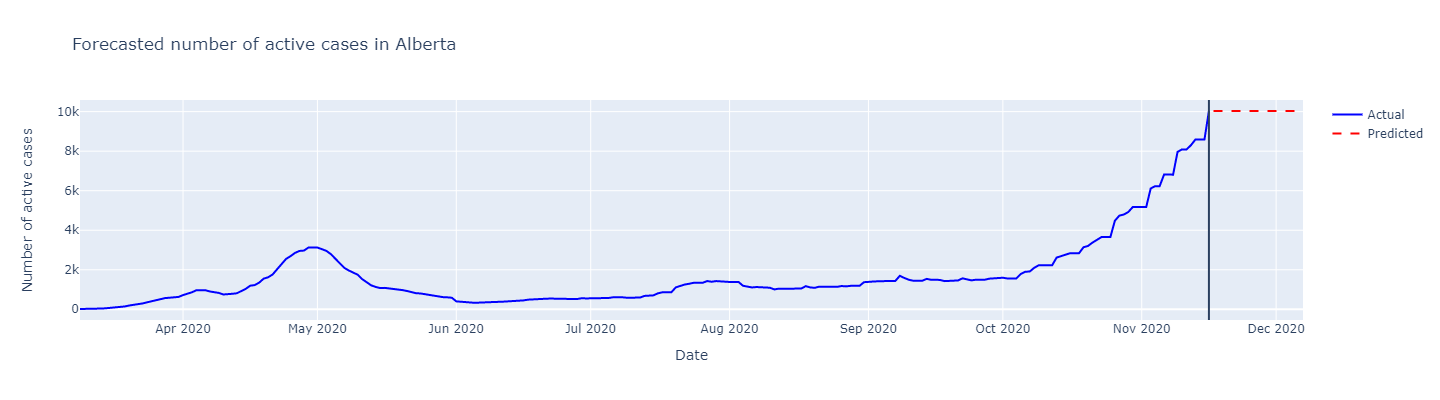

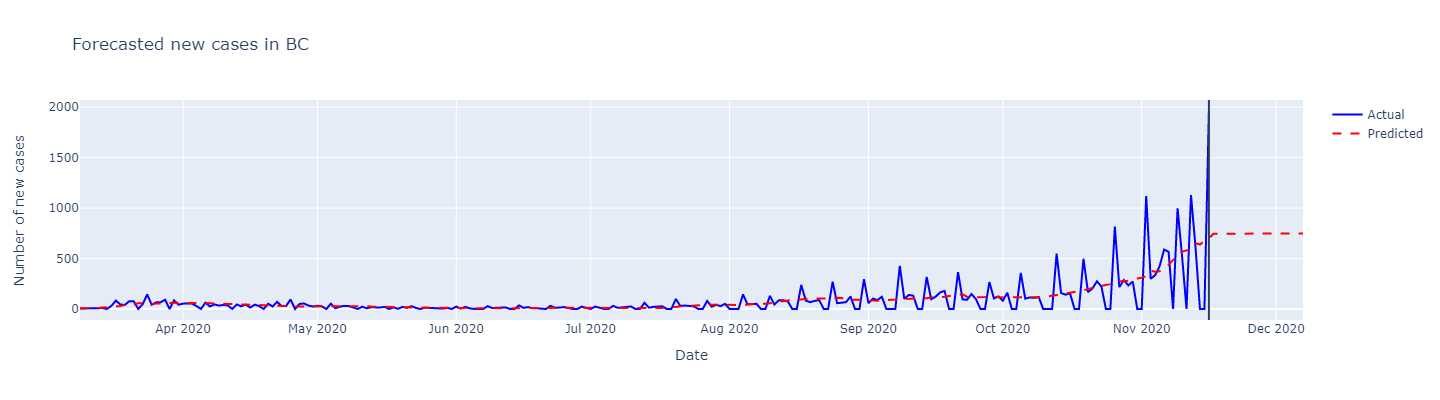

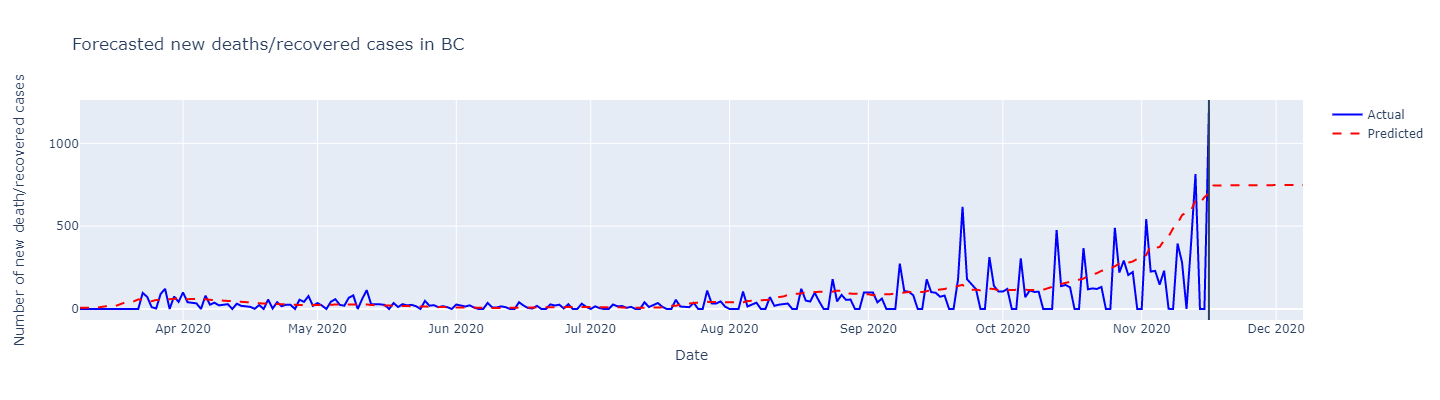

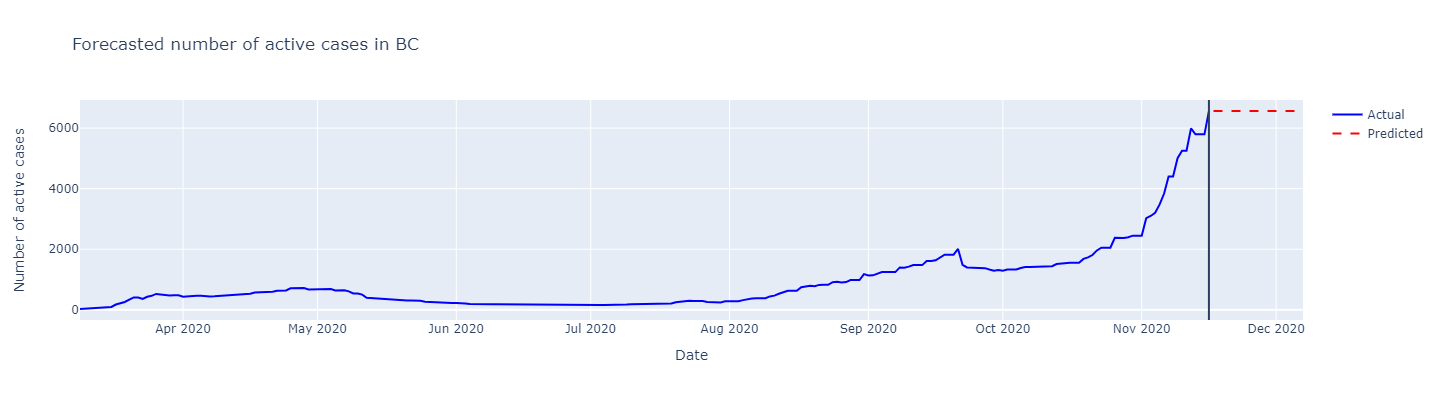

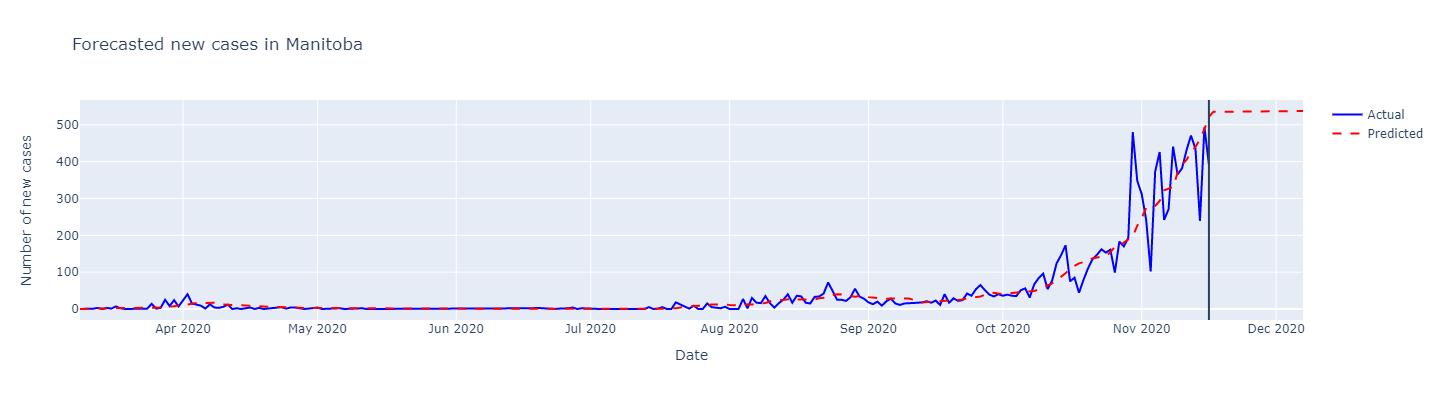

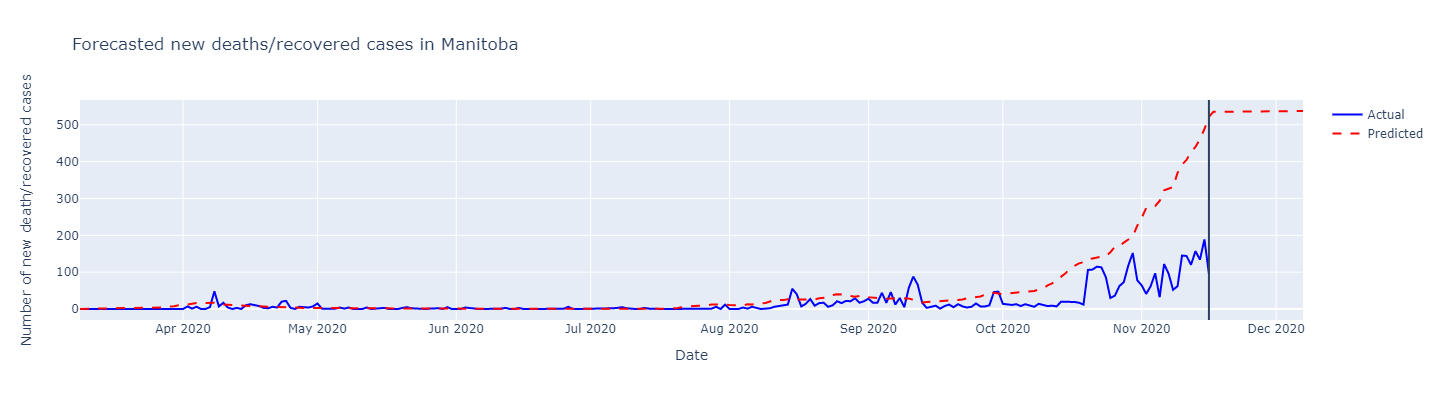

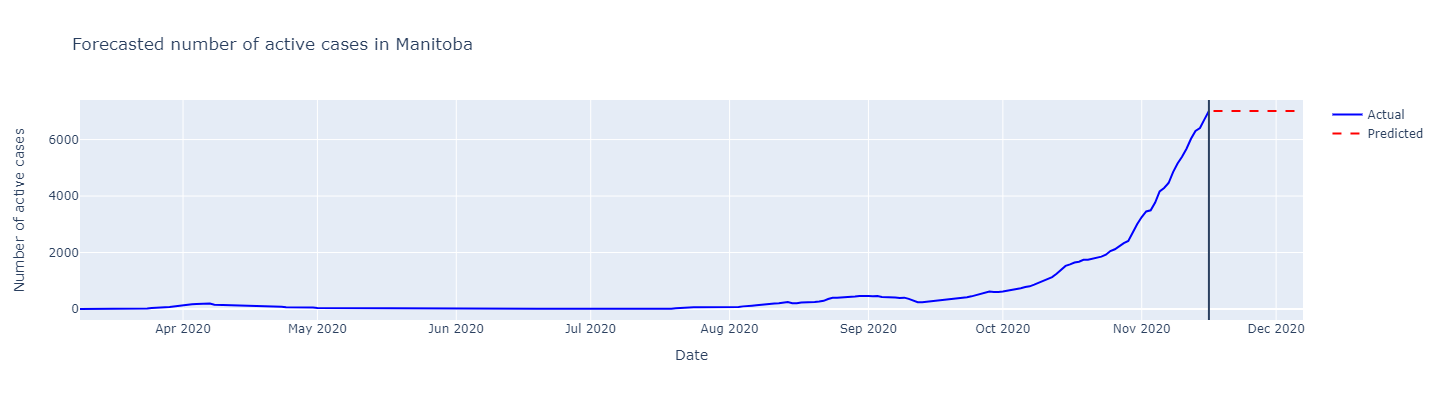

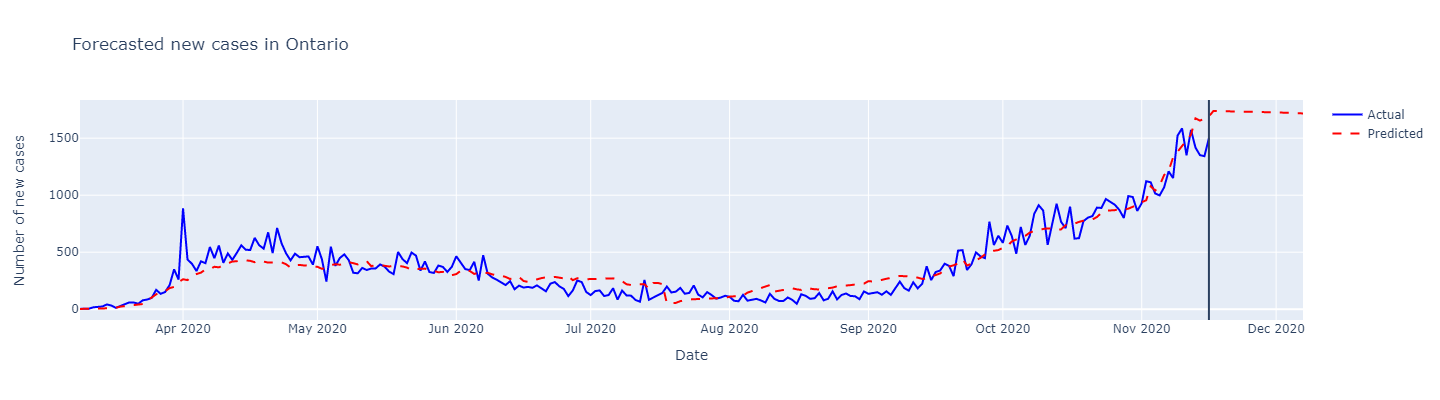

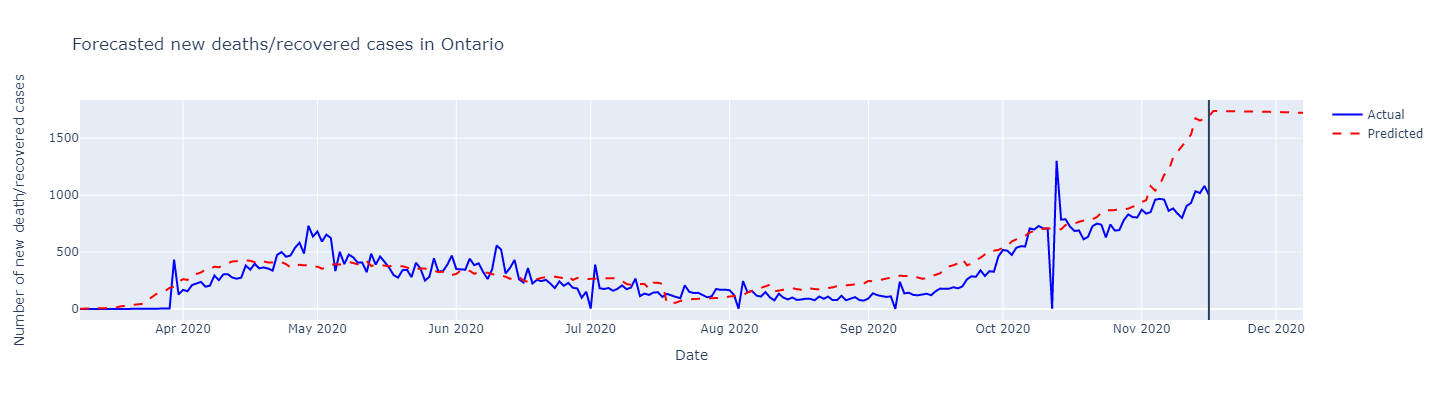

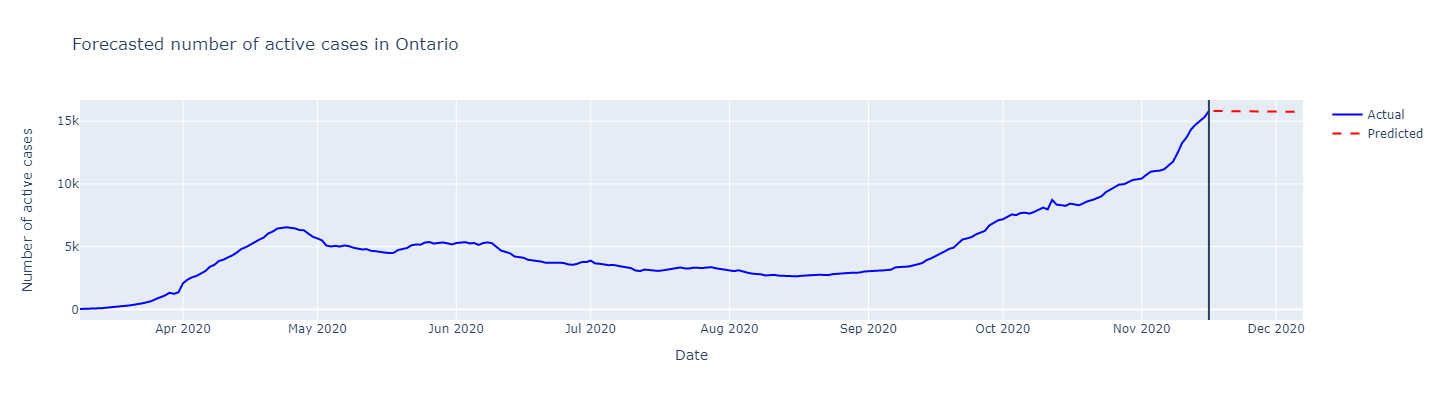

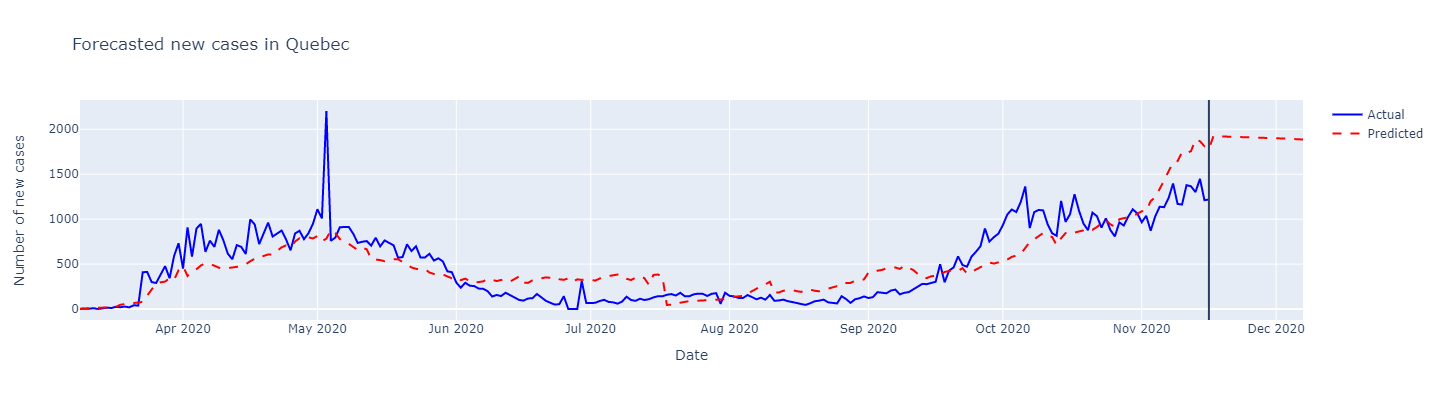

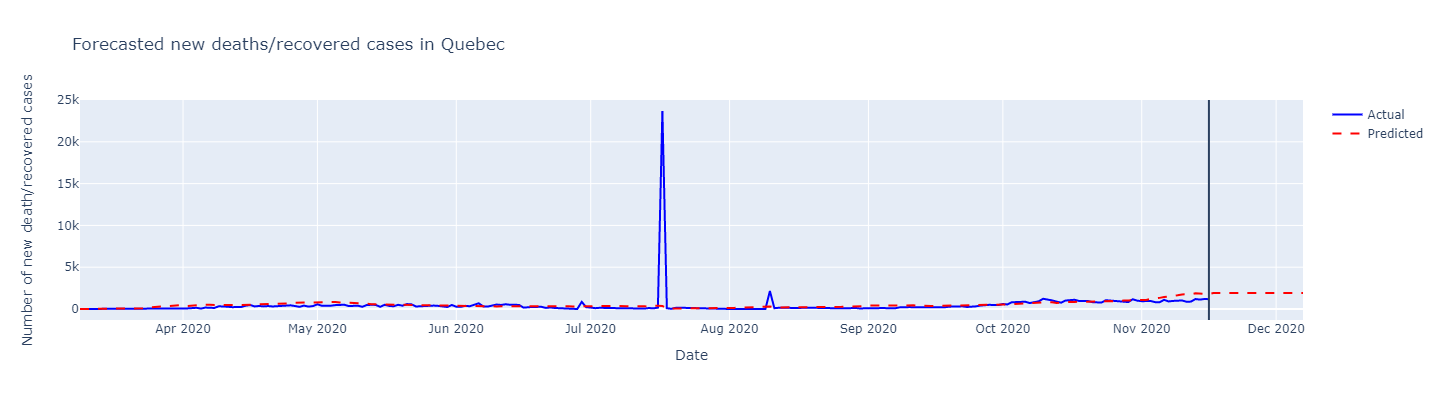

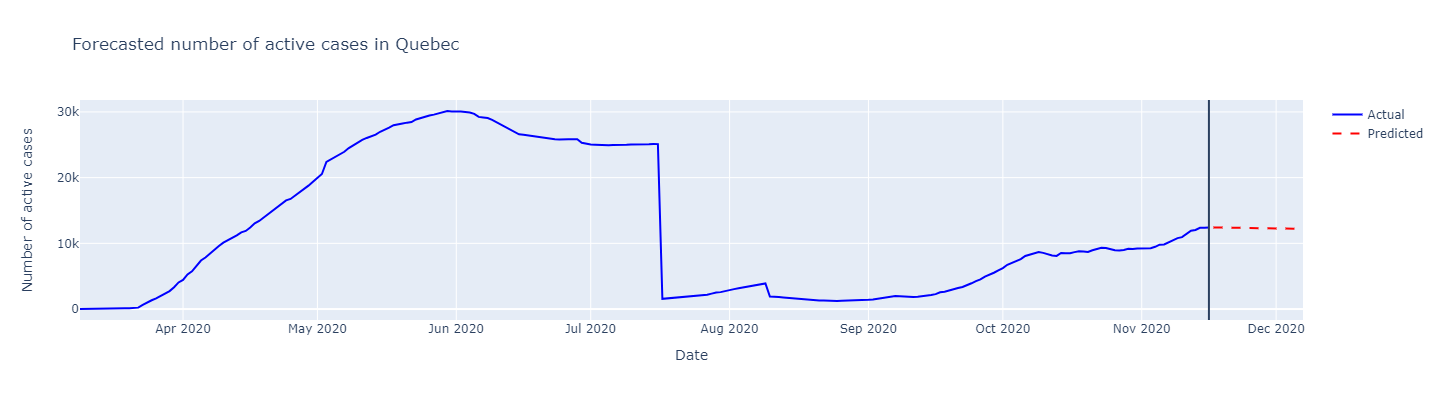

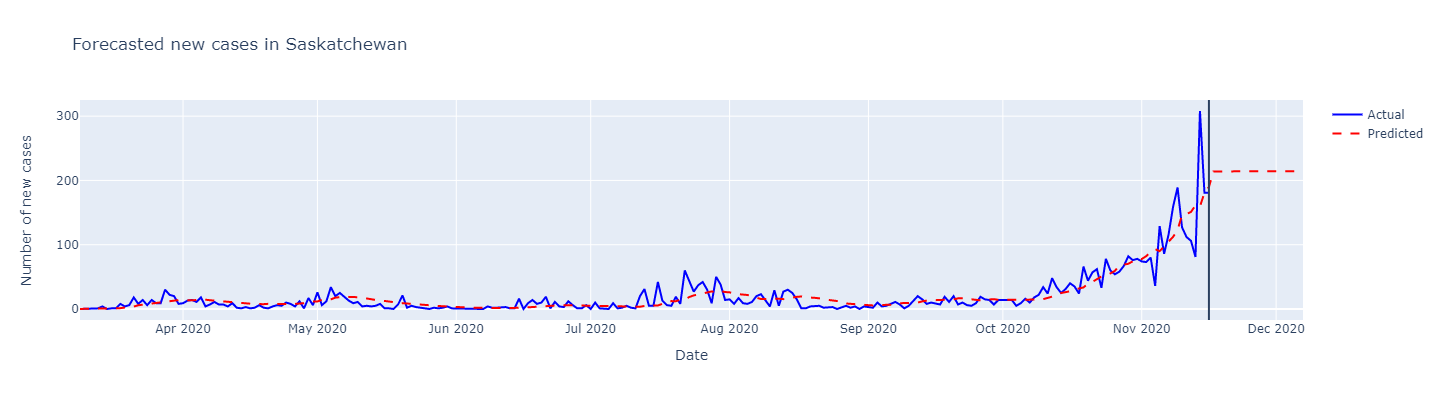

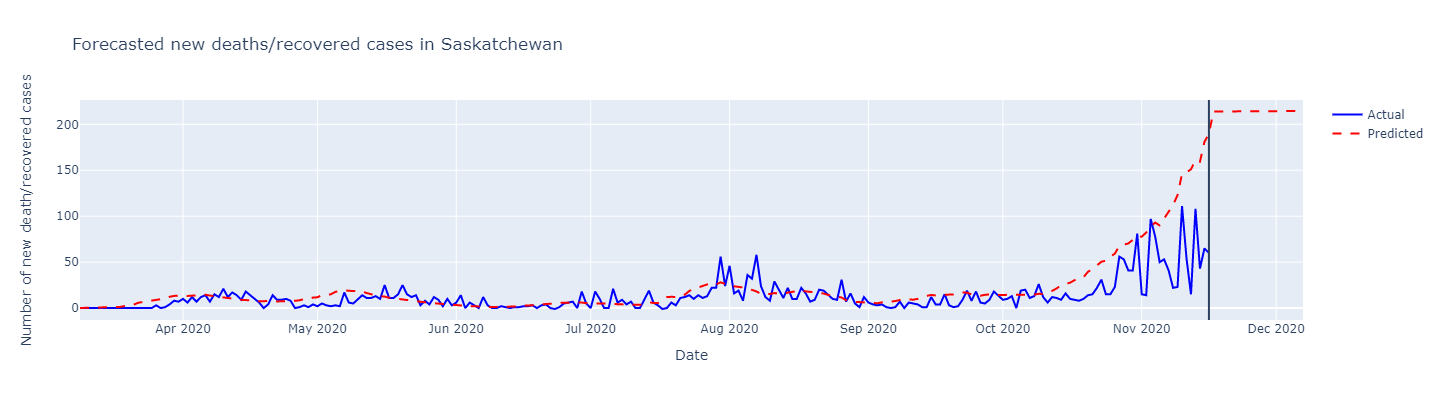

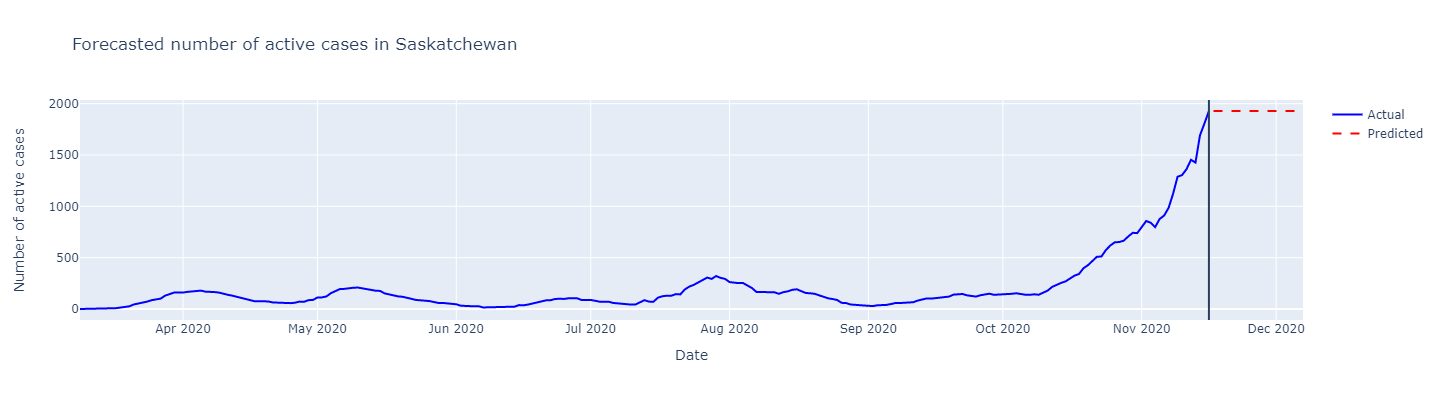

In [12]:
# Prediction plots for all provinces
provinces = active_cases_provinces['province'].unique()
for province in provinces:
    province_forecasts = forecasts.query('province == @province')
    
    plot_predictions(province_forecasts,
                     y = 'cases',
                     y_label = 'Number of new cases',
                     title = f'Forecasted new cases in {province}',
                     include_ci = False)

    plot_predictions(province_forecasts,
                     y = 'removed',
                     y_label = 'Number of new death/recovered cases',
                     title = f'Forecasted new deaths/recovered cases in {province}',
                     include_ci = False)
    
    plot_predictions(province_forecasts,
                     y = 'active_cases',
                     y_label = 'Number of active cases',
                     title = f'Forecasted number of active cases in {province}')

### Splines in GAM

In [13]:
# Fit model
model = StemPoissonRegressor(use_splines=True, lam_main=50, lam_other=100)
model.fit(X, Y)

In [14]:
# Get 3 week forecasts
forecasts = model.forecast(h=14)
forecasts = forecasts.merge(active_cases_provinces, how='left', on=['province', 'date'])

forecasts.tail(10)

province        date  active_cases_pred    cases_pred  removed_pred  \
1592      Manitoba  2020-11-29        7667.778824  8.157535e+01    803.520810   
1593       Ontario  2020-11-29       20119.273802  4.709562e+03   1920.594715   
1594        Quebec  2020-11-29       19262.435054  2.773639e+03   1327.809326   
1595  Saskatchewan  2020-11-29        4312.069241  9.913946e+02    220.854342   
1596       Alberta  2020-11-30      111644.292419  2.163221e-99   3814.637637   
1597            BC  2020-11-30       26744.697169  2.093712e-23   1215.831990   
1598      Manitoba  2020-11-30       39781.103664  3.259719e+04    483.867212   
1599       Ontario  2020-11-30       20035.796378  2.286023e+03   2369.500526   
1600        Quebec  2020-11-30       11712.494289  9.131217e+01   7641.252934   
1601  Saskatchewan  2020-11-30        3143.321841  6.281920e-02   1168.810219   

     is_forecast  cumulative_cases  cumulative_recovered  cumulative_deaths  \
1592        True               NaN                   NaN                NaN   
1593        True               NaN                   NaN                NaN   
1594        True               NaN                   NaN                NaN   
1595        True               NaN                   NaN                NaN   
1596        True               NaN                   NaN                NaN   
1597        True               NaN                   NaN                NaN   
1598        True               NaN                   NaN                NaN   
1599        True               NaN                   NaN                NaN   
1600        True               NaN                   NaN                NaN   
1601        True               NaN                   NaN                NaN   

      active_cases  active_cases_change  deaths  recovered  cases  population  \
1592           NaN                  NaN     NaN        NaN    NaN         NaN   
1593           NaN                  NaN     NaN        NaN    NaN         NaN   
1594           NaN                  NaN     NaN        NaN    NaN         NaN   
1595           NaN                  NaN     NaN        NaN    NaN         NaN   
1596           NaN                  NaN     NaN        NaN    NaN         NaN   
1597           NaN                  NaN     NaN        NaN    NaN         NaN   
1598           NaN                  NaN     NaN        NaN    NaN         NaN   
1599           NaN                  NaN     NaN        NaN    NaN         NaN   
1600           NaN                  NaN     NaN        NaN    NaN         NaN   
1601           NaN                  NaN     NaN        NaN    NaN         NaN   

      removed  susceptible  percent_susceptible  
1592      NaN          NaN                  NaN  
1593      NaN          NaN                  NaN  
1594      NaN          NaN                  NaN  
1595      NaN          NaN                  NaN  
1596      NaN          NaN                  NaN  
1597      NaN          NaN                  NaN  
1598      NaN          NaN                  NaN  
1599      NaN          NaN                  NaN  
1600      NaN          NaN                  NaN  
1601      NaN          NaN                  NaN

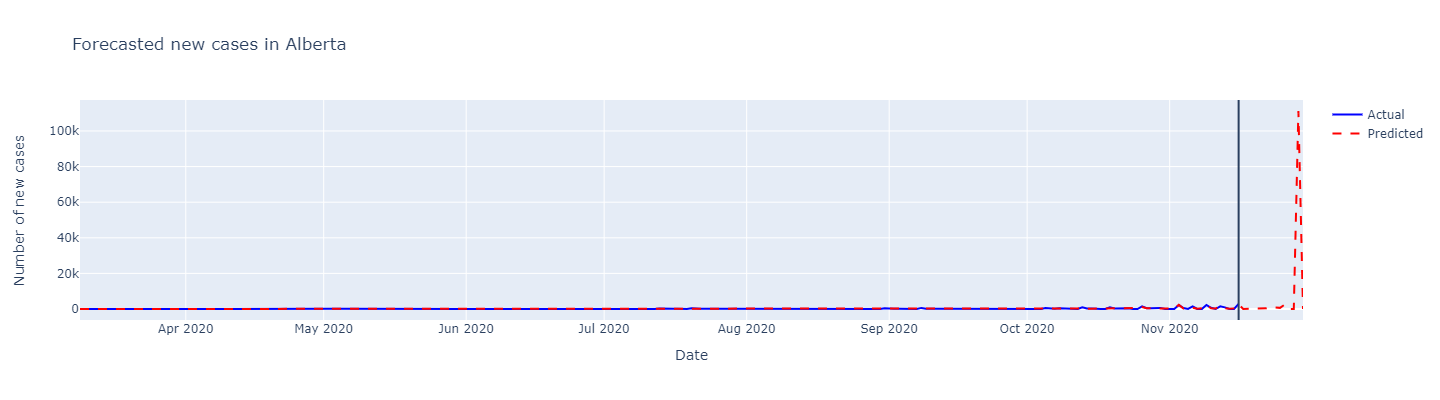

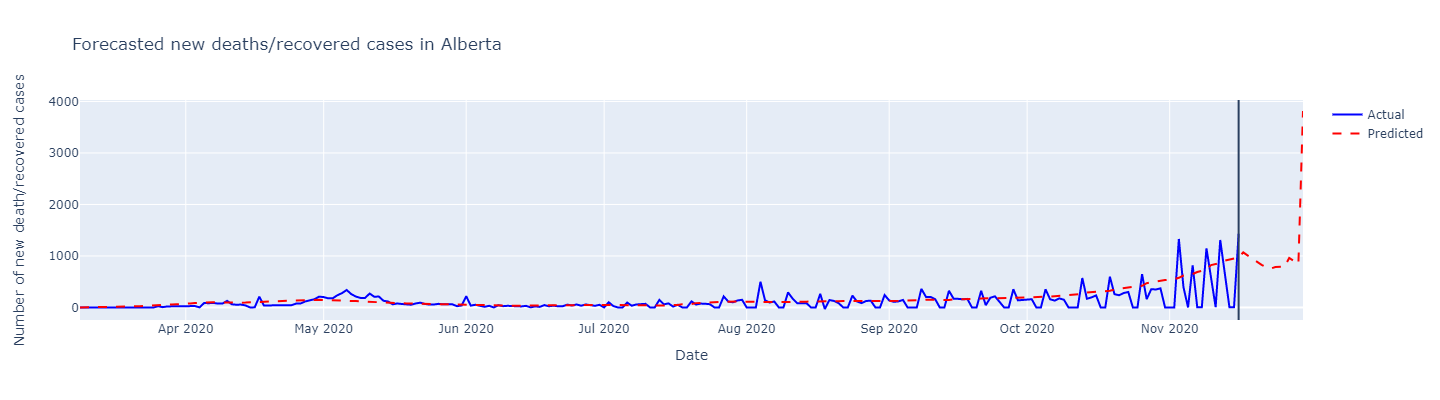

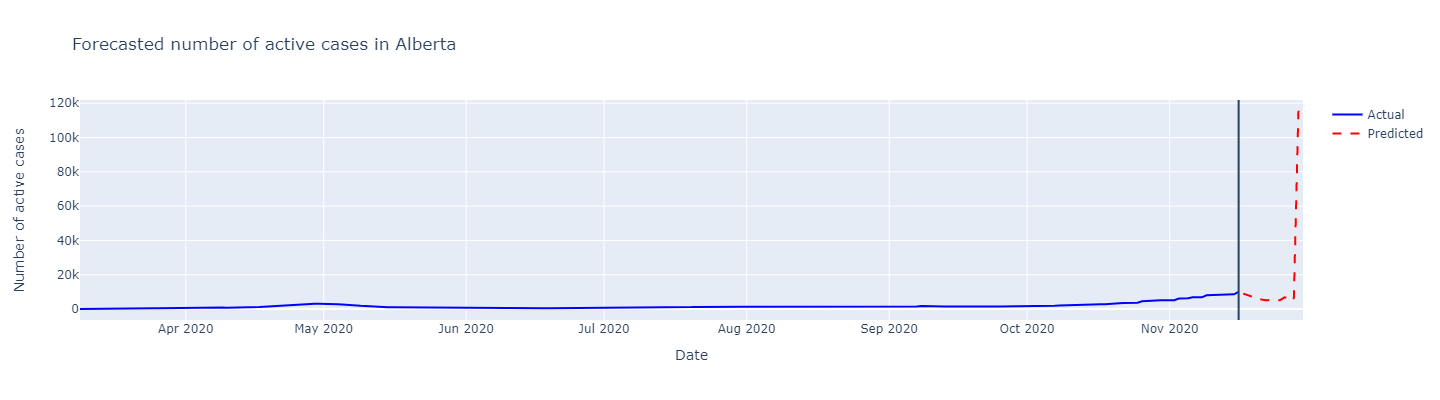

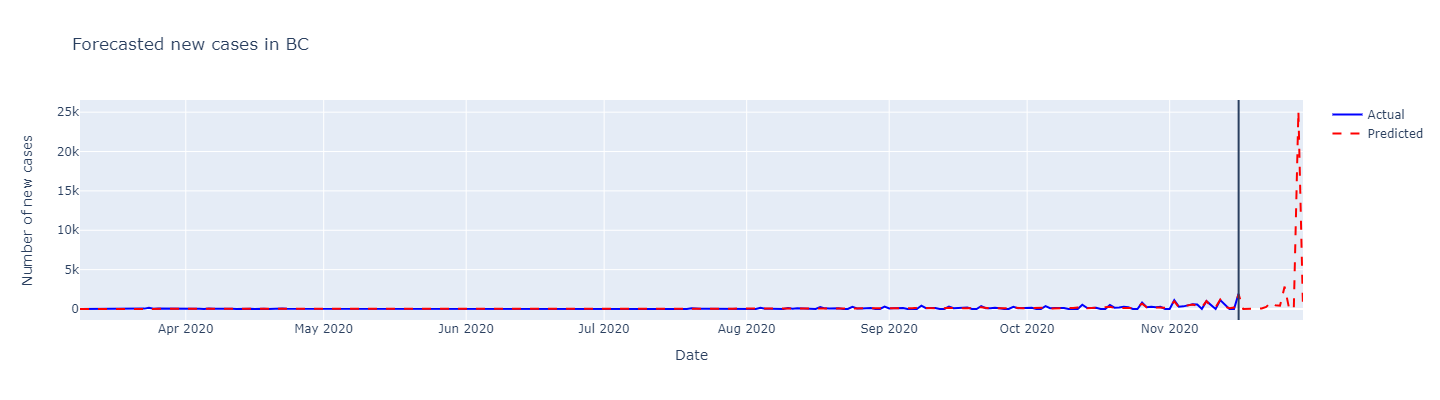

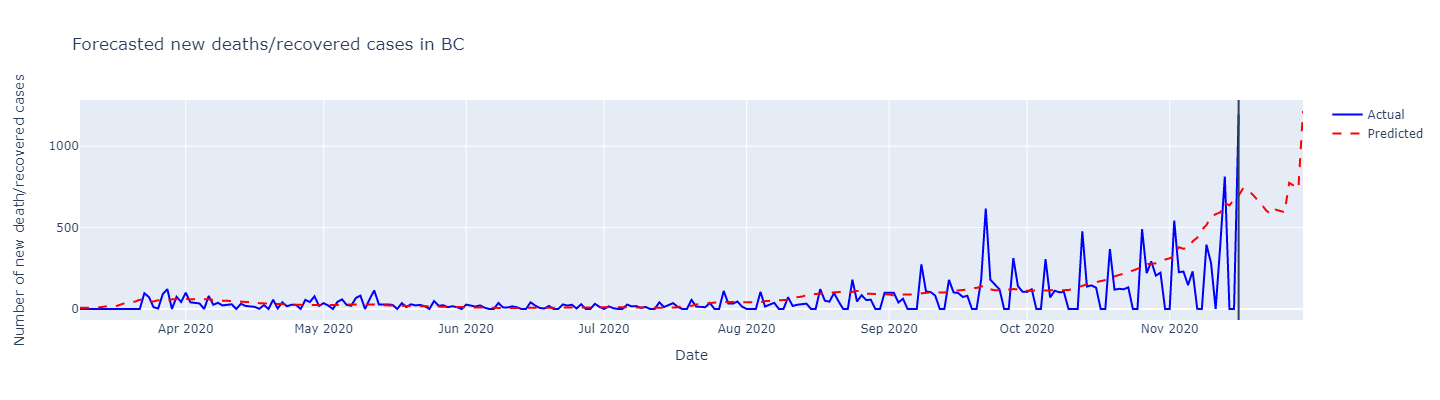

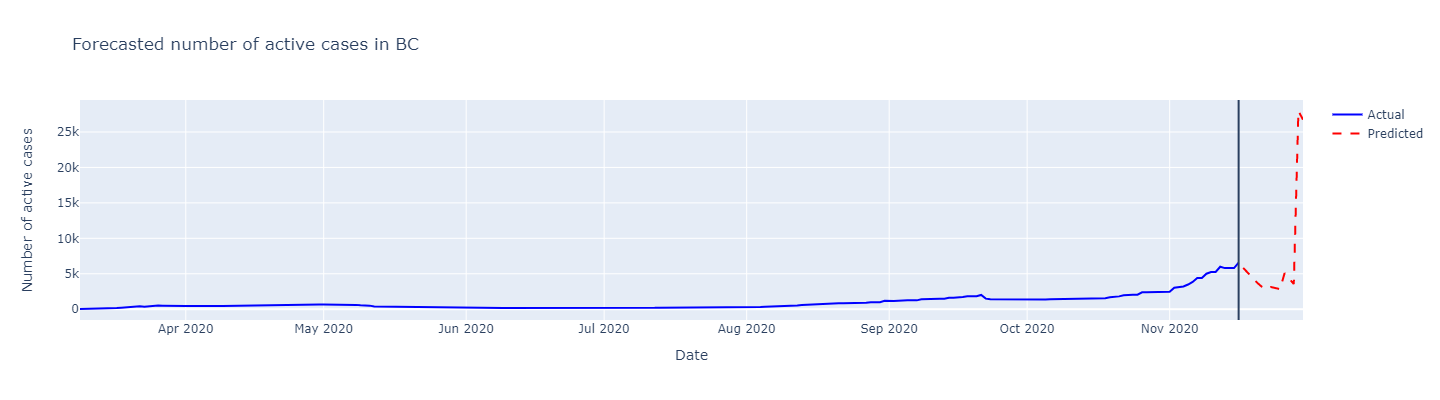

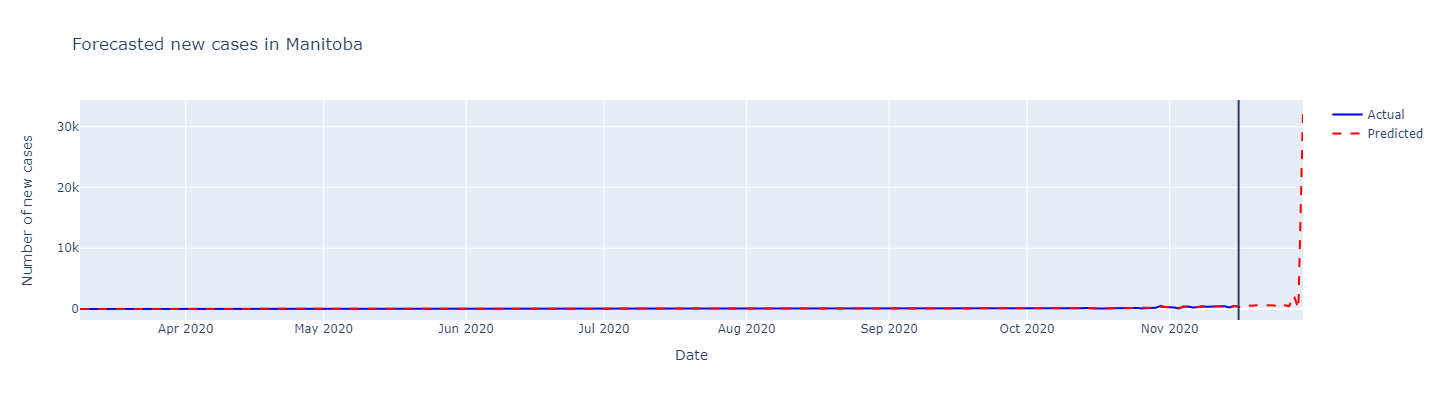

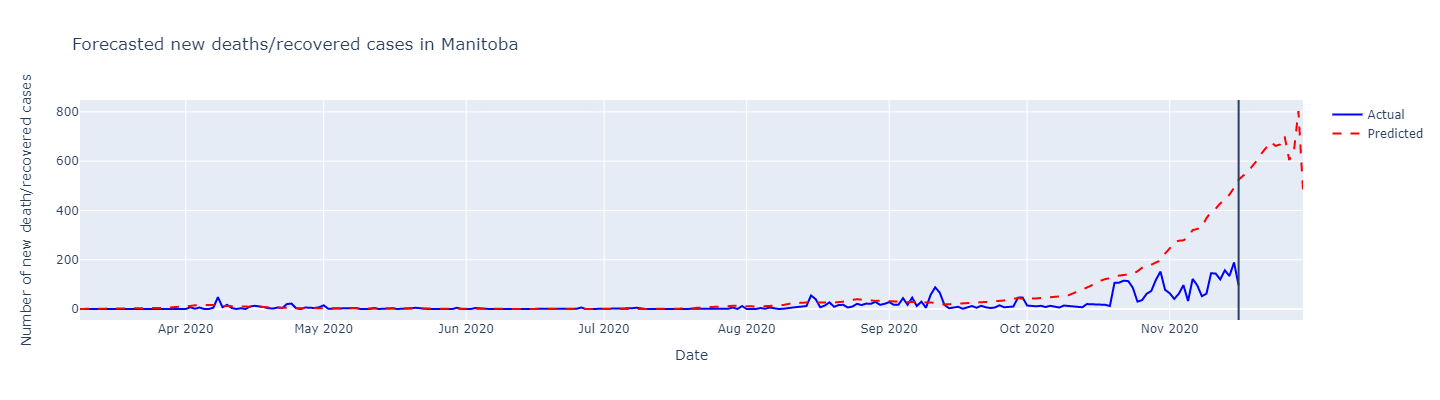

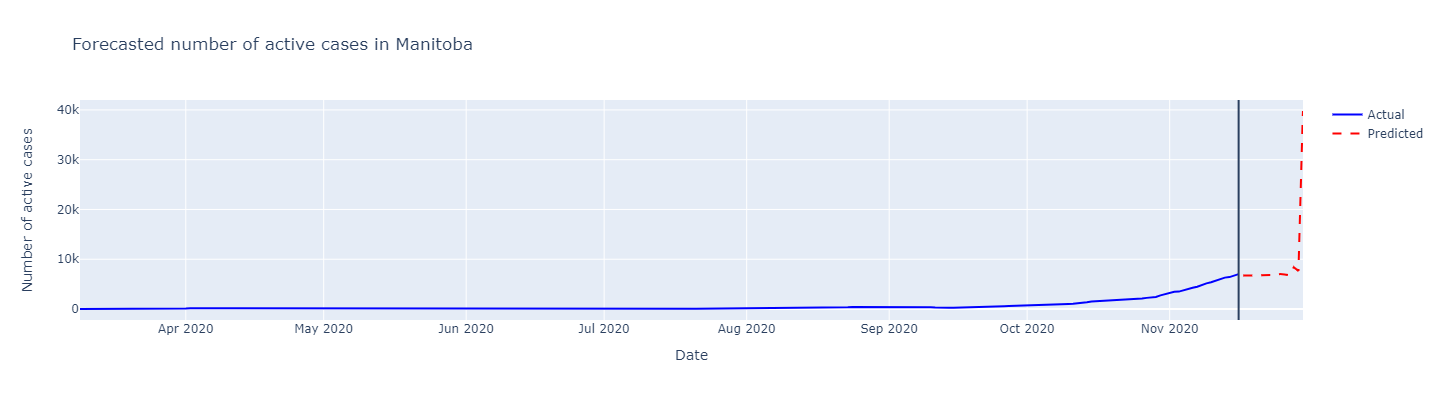

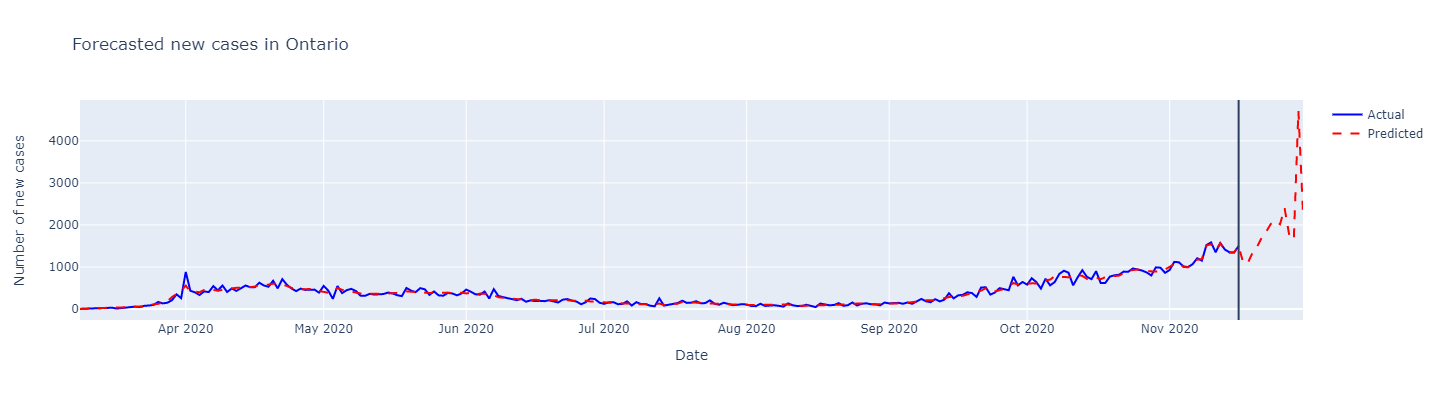

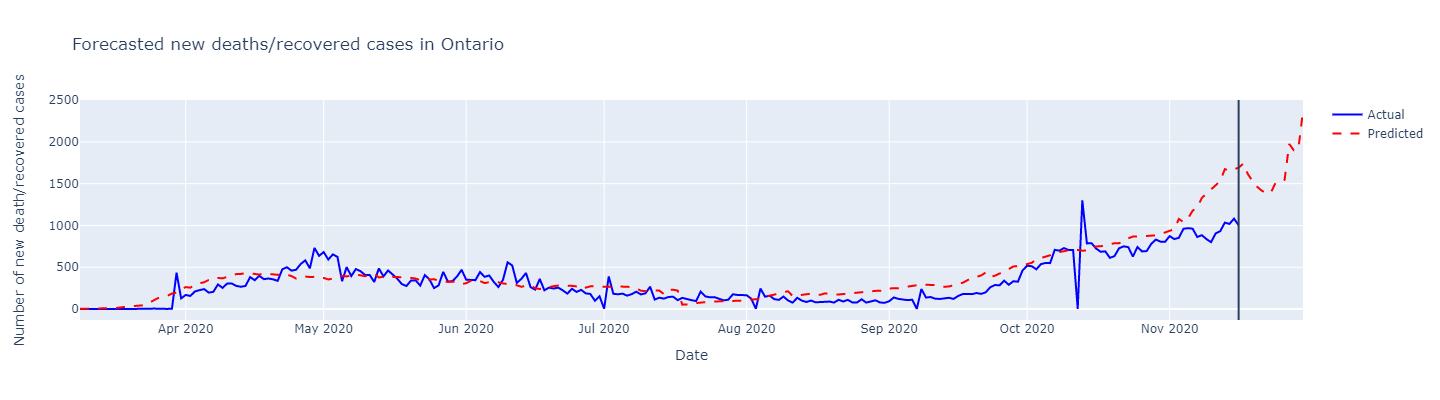

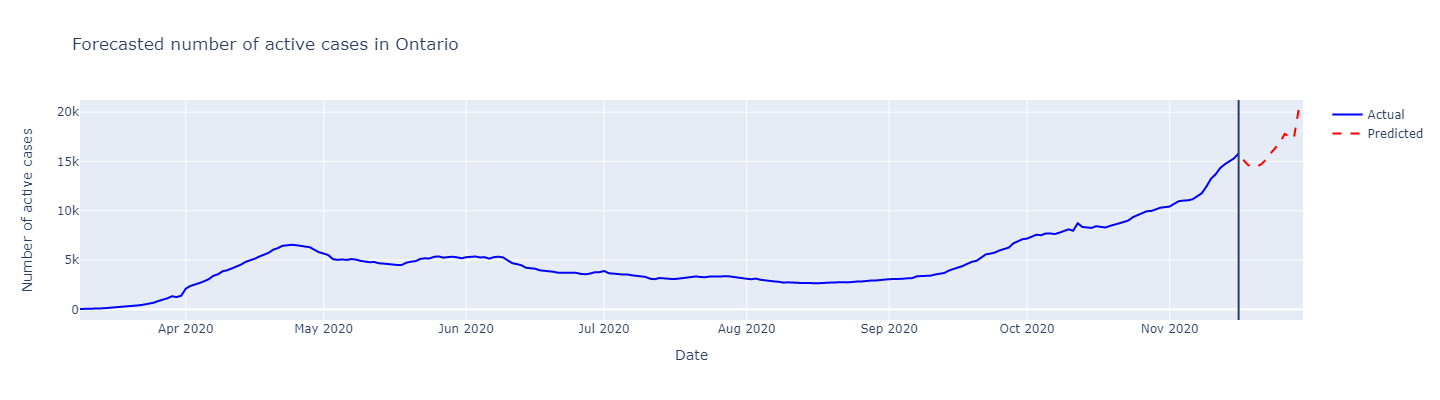

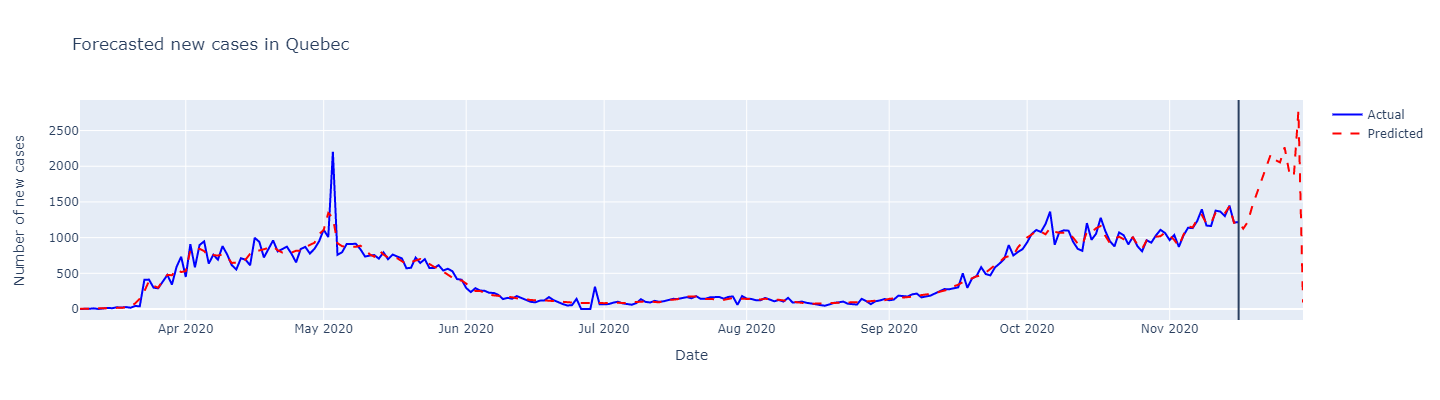

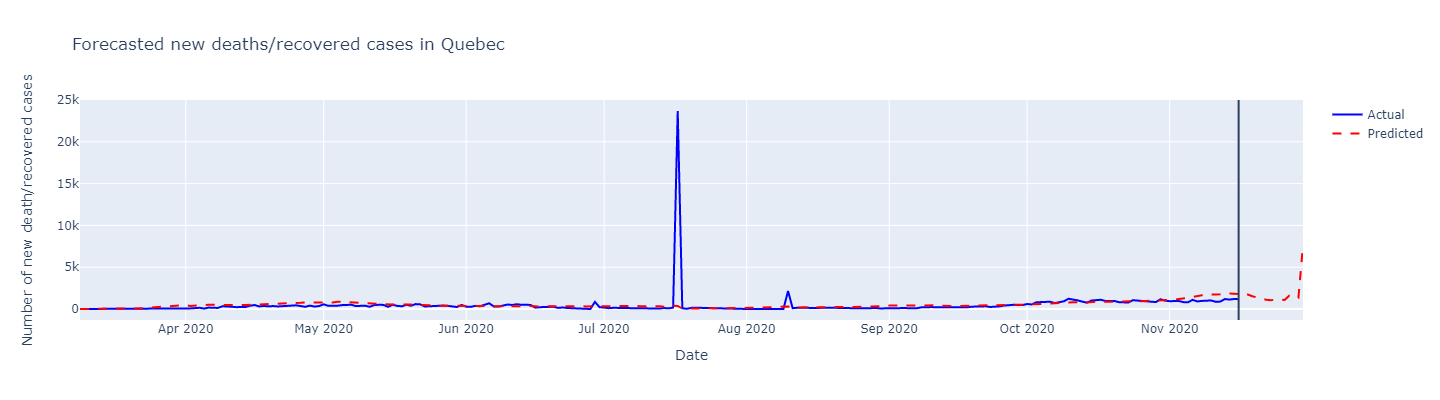

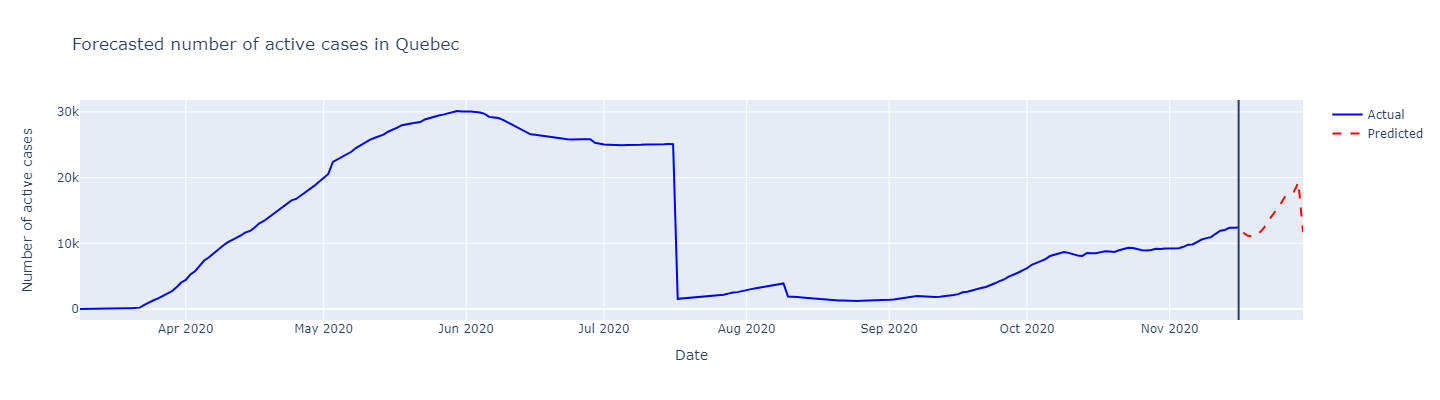

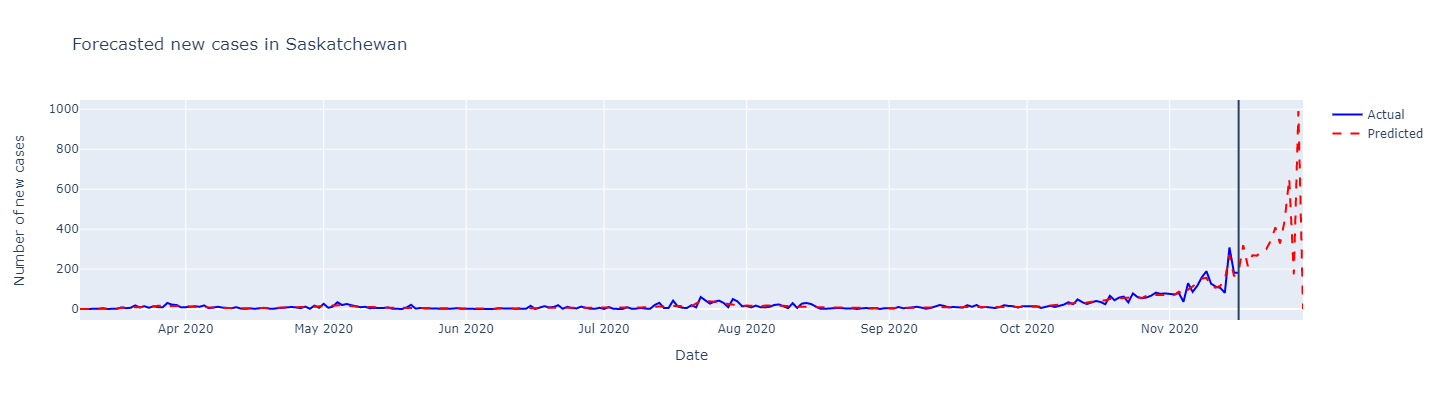

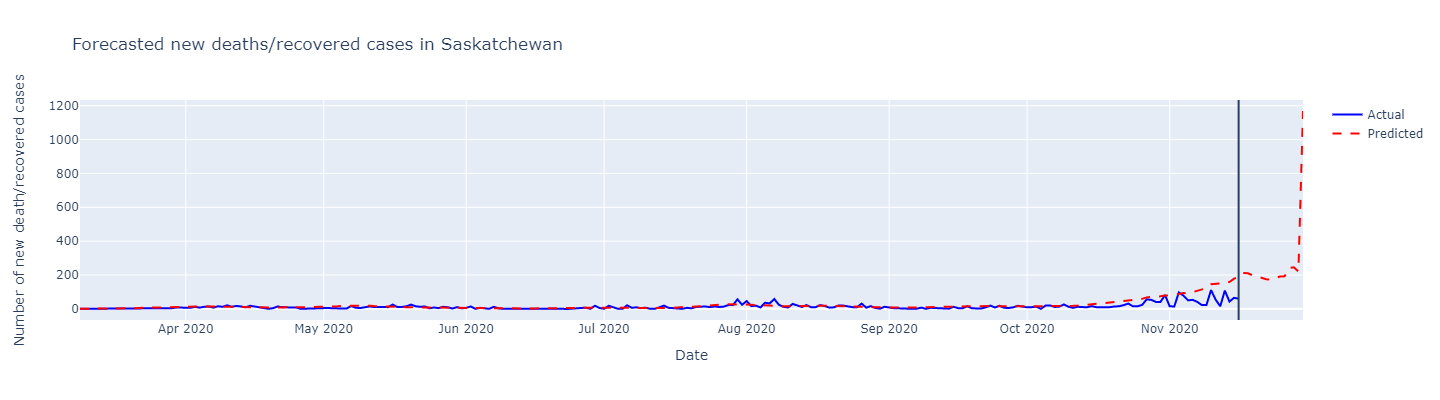

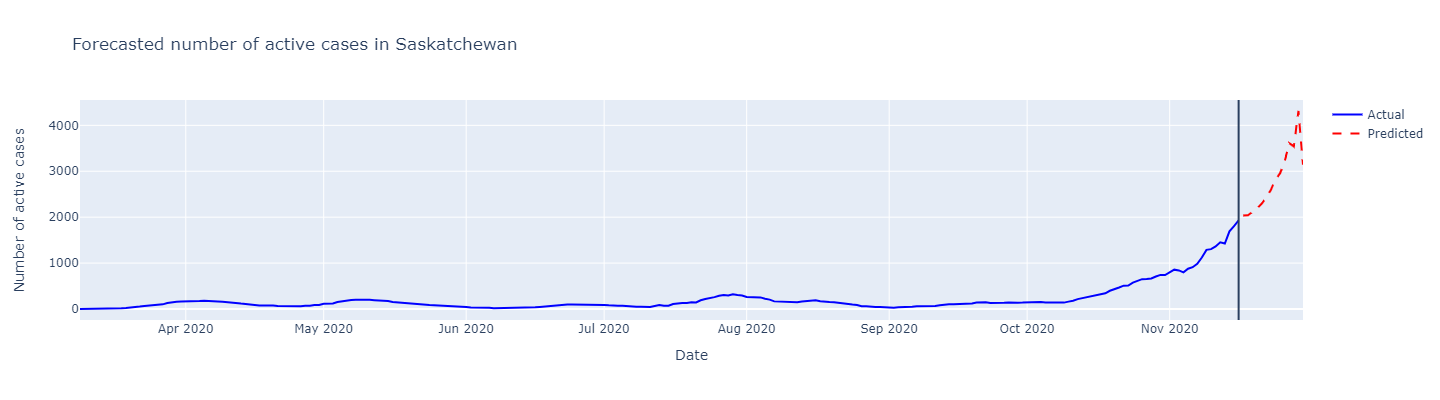

In [15]:
# Prediction plots for all provinces
provinces = active_cases_provinces['province'].unique()
for province in provinces:
    province_forecasts = forecasts.query('province == @province')
    
    plot_predictions(province_forecasts,
                     y = 'cases',
                     y_label = 'Number of new cases',
                     title = f'Forecasted new cases in {province}',
                     include_ci = False)

    plot_predictions(province_forecasts,
                     y = 'removed',
                     y_label = 'Number of new death/recovered cases',
                     title = f'Forecasted new deaths/recovered cases in {province}',
                     include_ci = False)
    
    plot_predictions(province_forecasts,
                     y = 'active_cases',
                     y_label = 'Number of active cases',
                     title = f'Forecasted number of active cases in {province}')

### Cross validation